데이터 출처 : https://www.kaggle.com/gregorut/videogamesales

## 주제

* 비디오 게임 데이터셋을 이용하여 다음 분기 게임 설계하기

### 분석 목적
- 비디오 게임의 장르 결정
- 게임을 지원하는 플랫폼 선정
- 주요 출고 지역 선정

### 목차
1. 데이터 생성 및 설명
2. EDA 및 전처리
3. Feature engineering
4. 분석 및 결과
5. 결론

### 1. 데이터 생성 및 설명

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#colab plot의 한글깨짐 해결

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
location = './vgames2.csv'

data = pd.read_csv(location)

data.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


### 2. EDA 및 전처리

In [ ]:
#데이터 정보 확인

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


* 무의미한 Unnamed: 0 칼럼이 속해있는 것을 볼 수 있음<br>
* NA값이 포함된 칼럼들이 있음을 알 수 있음<br>
* 출고량들이 object형태로 저장되어 있음을 알 수 있음

In [ ]:
#Unnamed: 0 칼럼 제거

data.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
#칼럼별 na값 확인

data.isna().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [ ]:
#na제거

data.dropna(how = 'any', inplace = True)

In [ ]:
#중복 row제거

data.drop_duplicates(inplace = True)

In [ ]:
#출고량 칼럼에 속해있는 M, K를 처리하기 위한 함수생성

def pre_MK(x):
    if 'K' in x:
        x = x[:len(x)-1]
        x = float(x)*1000
    elif 'M' in x:
        x = x[:len(x)-1]
        x = float(x)*1000000
    else:
        x = float(x)*1000000
    return x

#함수 적용
for col in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    data[col] = data[col].apply(pre_MK)

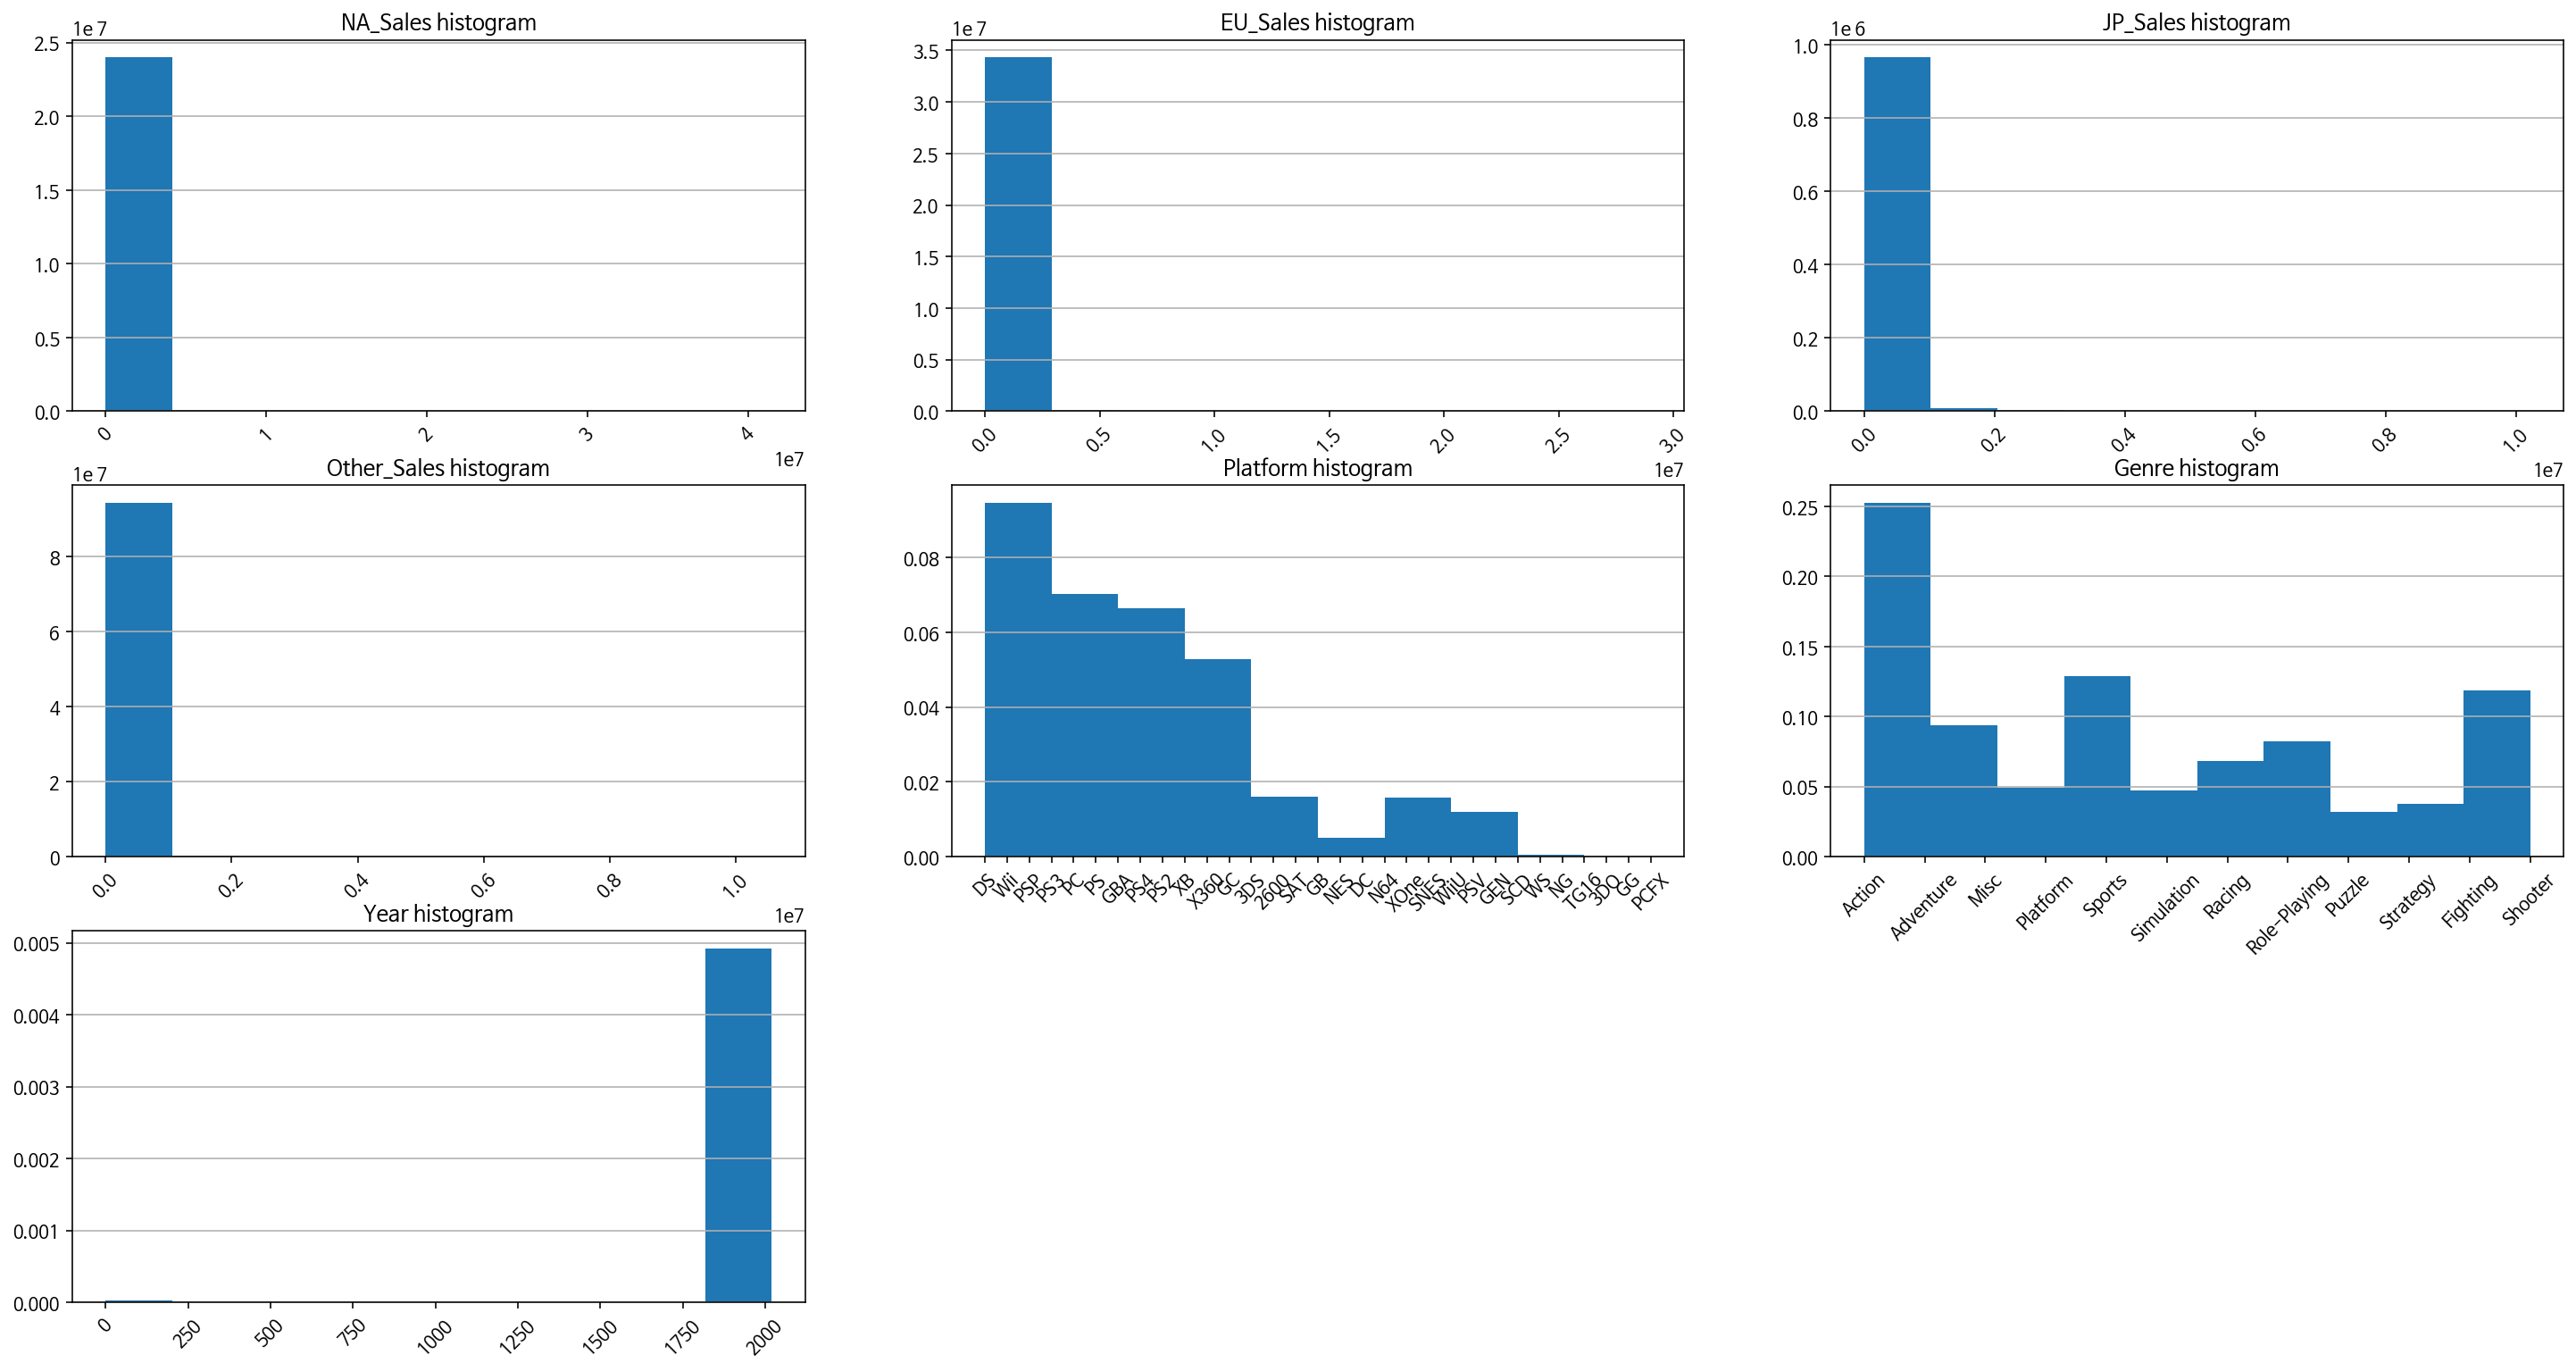

In [ ]:
#칼럼별 데이터 분포 확인

# fig, ax = plt.subplots()

plt.figure(figsize = (25,13))

for i, col in enumerate(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales','Platform', 'Genre', 'Year']):
    plt.subplot(3,3,i+1)

    plt.hist(data[col], density=True)

    plt.title(col + ' histogram')
    plt.xticks(rotation=45)
    plt.grid(True, axis = 'y')
plt.show()

Year histogram에서 이상치로 의심되는 데이터들이 발견됨
1. 비디오 게임은 대략 1950년도에 처음으로 개발되었는데 0~250년 사이에 데이터가 있는 것을 확인
2. 십의자리까지 표기하여 출시년도가 표시된 데이터들이 있는 것을 발견

In [ ]:
#Year 데이터의 이상형태확인

print('세자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 3)]))

print('두자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 2)]))

print('한자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 1)]))

세자리 수 Year 데이터의 개수는 :  0
두자리 수 Year 데이터의 개수는 :  47
한자리 수 Year 데이터의 개수는 :  53


세자리 수 Year 데이터의 개수는 :  0
두자리 수 Year 데이터의 개수는 :  0
한자리 수 Year 데이터의 개수는 :  0


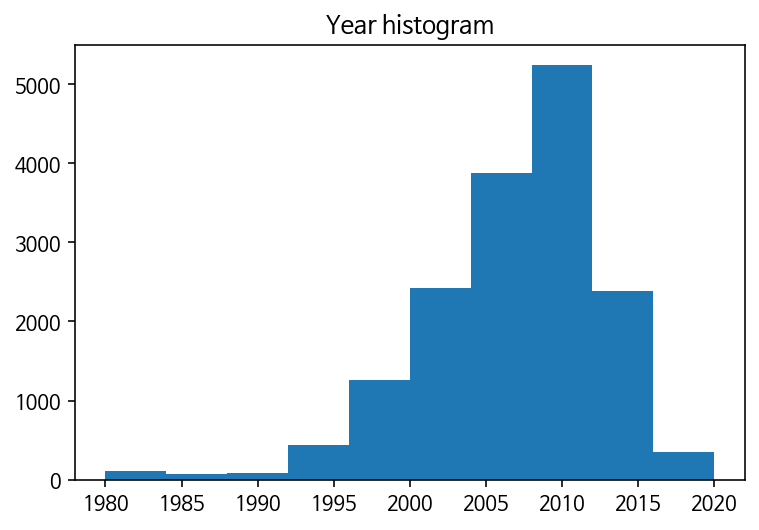

In [ ]:
#Year 데이터 처리 함수생성

def pre_year(x):
    if len(str(int(x))) == 1:
        x = x+2000
    elif len(str(int(x))) == 2:
        if int(x) <= 25:
            x = x+2000
        else:
            x = x+1900
    return x

#함수 적용
data['Year'] = data['Year'].apply(pre_year)

#결과 확인
print('세자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 3)]))

print('두자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 2)]))

print('한자리 수 Year 데이터의 개수는 : ', len(data[data['Year'].apply(lambda x : len(str(int(x))) == 1)]))

#Year 분포 확인

plt.hist(data['Year'])
plt.title('Year histogram')
plt.show()

분포가 정상화된 것을 볼 수 있음

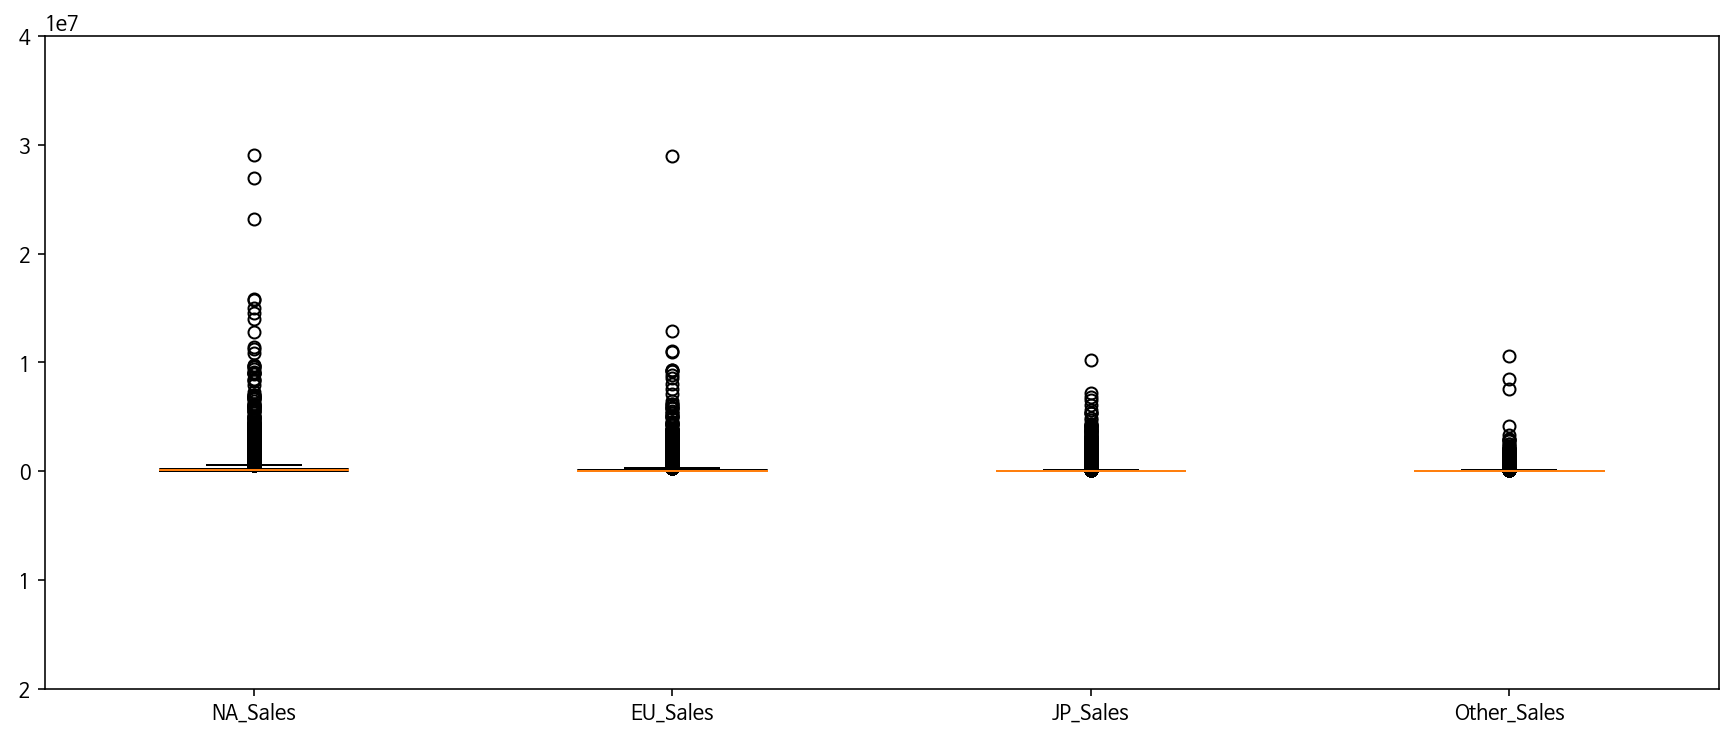

In [ ]:
#boxplot을 이용하여 float 칼럼들의 분포확인

plt.figure(figsize=(15,6))
plt.boxplot([data['NA_Sales'],data['EU_Sales'],data['JP_Sales'],data['Other_Sales']])
plt.ylim((-20000000,40000000))
plt.xticks([1, 2, 3, 4], 

           ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
plt.show()

대부분의 출고량이 0~10000000 사이에 집중되어 있음을 알 수 있다.

### 3. Feature engineering

In [ ]:
#모든 출고량을 나타내주는 total 칼럼 생성

data['total'] = data['NA_Sales'] + data['JP_Sales'] + data['EU_Sales'] + data['Other_Sales']

In [ ]:
# 지역별 sales를 2차원으로 PCA

data['total'].describe()

total_label = []

In [ ]:
#total sales에 따라 라벨을 정해주는 함수 생성
def my_label(x):
    if x >= 430000:
        total_label.append(2)
    elif x < 430000 and x >= 60000:
        total_label.append(1)
    else:
        total_label.append(0)

    return 0

#함수 적용
execute = data['total'].apply(my_label)

In [ ]:
#scaling
scaler = StandardScaler()

pca_data = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

scaler.fit(pca_data)
scaled_pca_data = scaler.transform(pca_data)

#2차원으로 pca
pca = PCA(2)

pca_data2 = pca.fit_transform(scaled_pca_data)

print('2차원 PCA로 나타내는 분산 비율은 : ',sum((pca.explained_variance_ratio_)))

pca_data2 = pd.DataFrame(pca_data2, columns = ['X', 'Y'])
pca_data2['label'] = total_label

2차원 PCA로 나타내는 분산 비율은 :  0.8632086304319948


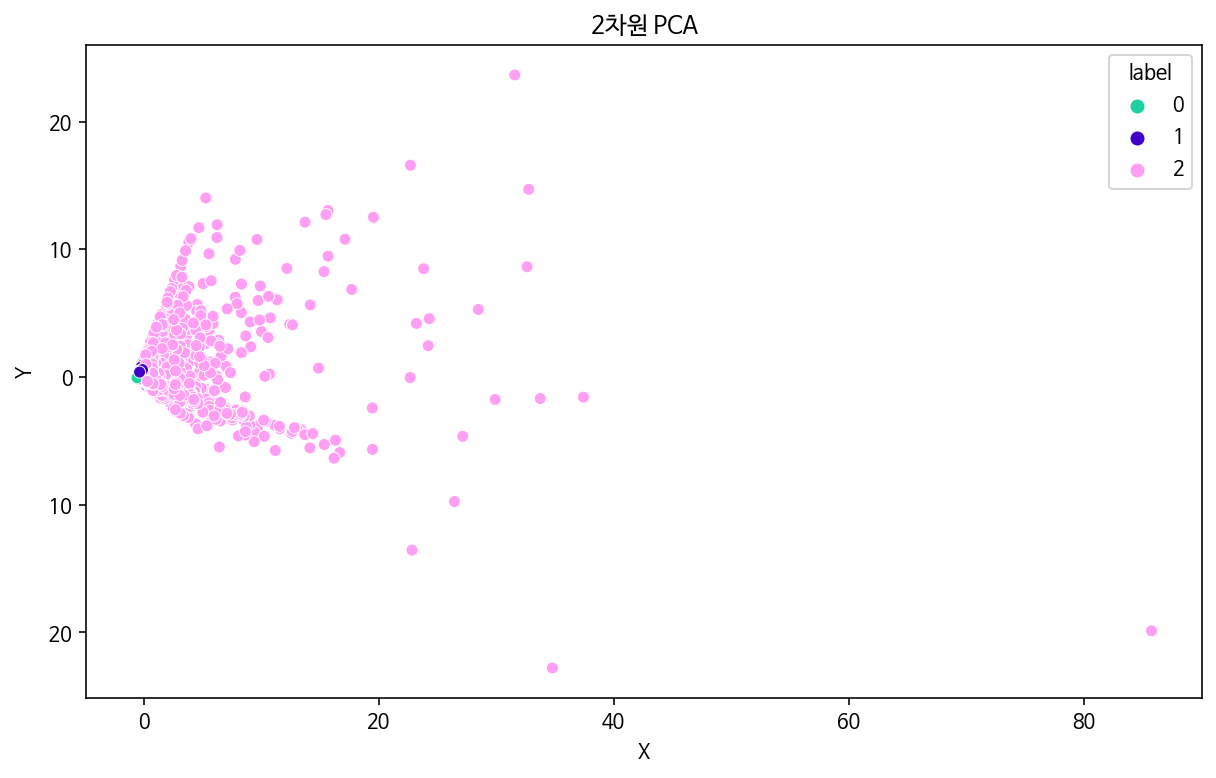

In [ ]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    x = 'X',
    y = 'Y',
    data = pca_data2,
    hue = 'label',
    palette = {0 : '#1dd1a1', 1 : '#4000c7', 2 : '#ff9ff3'}
);

plt.title('2차원 PCA')
plt.show()


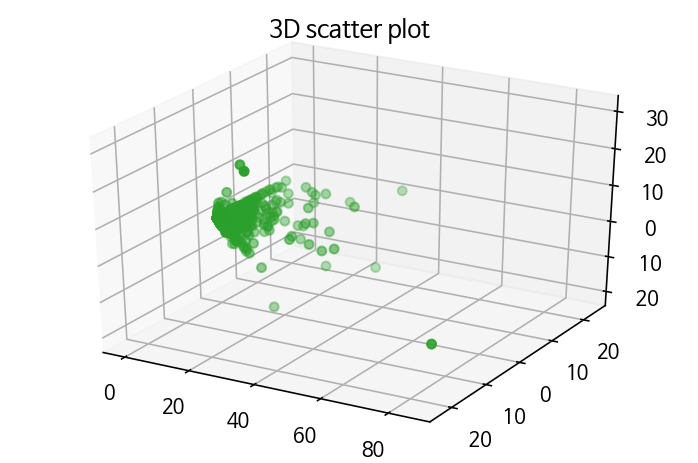

In [ ]:
#3차원으로 pca

pca3 = PCA(3)

pca_data3 = pca3.fit_transform(scaled_pca_data)
pca_data3 = pd.DataFrame(pca_data3, columns = ['X', 'Y', 'Z'])
pca_data3['label'] = total_label

threedee = plt.figure().gca(projection='3d')

for i in pca_data3['label'].unique():
    threedee.scatter(pca_data3[pca_data3['label']==i]['X'],pca_data3[pca_data3['label']==i]['Y'],pca_data3[pca_data3['label']==i]['Z'])

plt.title('3D scatter plot')
plt.show()

그래프에서 볼 수 있듯 PCA를 통해서 라벨에 따른 특성을 알아보려했으나 별로 유의하지 않아보인다.

### 4. 분석 및 결과
1) 지역에 따른 선호하는 게임 장르<br>
2) 연도별 게임의 트렌드<br>
- 연도별 비디오게임 출고량의 트렌드<br>
- 연도별 비디오게임 장르의 트렌드<br>

3) 출고량이 높은 게임에 대한 분석 및 시각화 프로세스<br>
4) 출고량이 높은 게임에 적합한 플랫폼

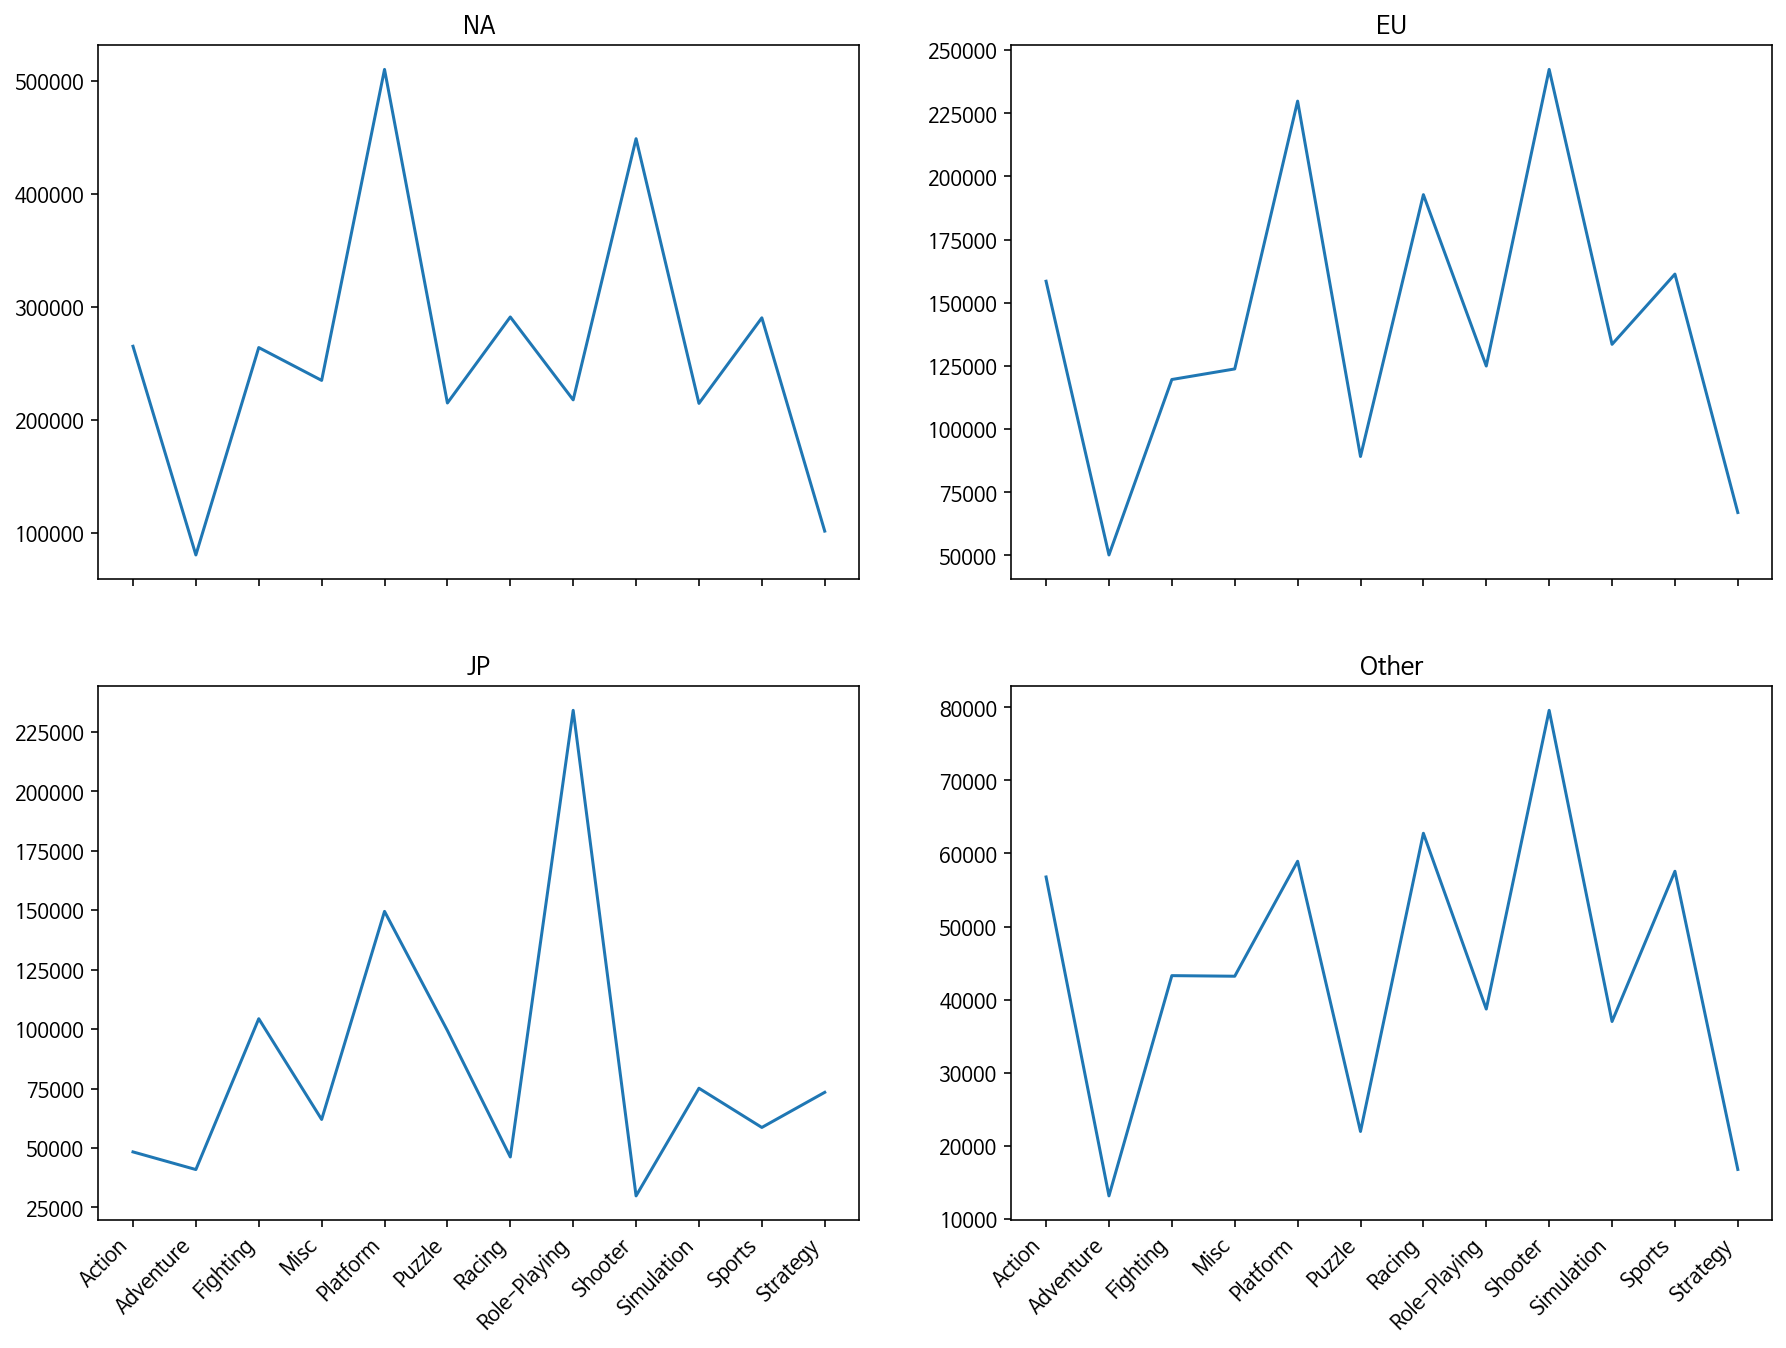

In [ ]:
#지역에 따라 선호하는 게임 장르가 다를까?

nasale = data.groupby('Genre')['NA_Sales'].mean()
eusale = data.groupby('Genre')['EU_Sales'].mean()
jpsale = data.groupby('Genre')['JP_Sales'].mean()
othersale = data.groupby('Genre')['Other_Sales'].mean()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

ax[0,0].plot(nasale)
ax[0,0].set_title('NA')

ax[0,1].plot(eusale)
ax[0,1].set_title('EU')

ax[1,0].plot(jpsale)
ax[1,0].set_title('JP')

ax[1,1].plot(othersale)
ax[1,1].set_title('Other')

fig.autofmt_xdate (rotation = 45) #한번에 x축 레이블 돌려주기

plt.show()

그래프에서 볼 수 있듯 NA와 EU. Other의 장르별 출고량은 Platform, Shooter에서 높은 값을 가지는 형태이다.<br> 
또한 앞의 두 장르 뿐만 아니라 모든 장르에서 NA, EU와 Other의 출고량은 매우 유사한 패턴을 가진다.<br>
JP는 Platform장르에서 높은 값을 가진다는 점은 다른 지역과 유사하다.<br>
하지만 Role-Playing 장르에서 최대값을 갖는점을 비롯해 거의 모든 장르별 출고량 패턴이 앞의 지역들과 차이가 나는 것을 확인할 수 있다.<br><br>
결론적으로 일본을 제외하고 전세계적으로 선호하는 게임 장르가 유사하다고 판단할 수 있다.

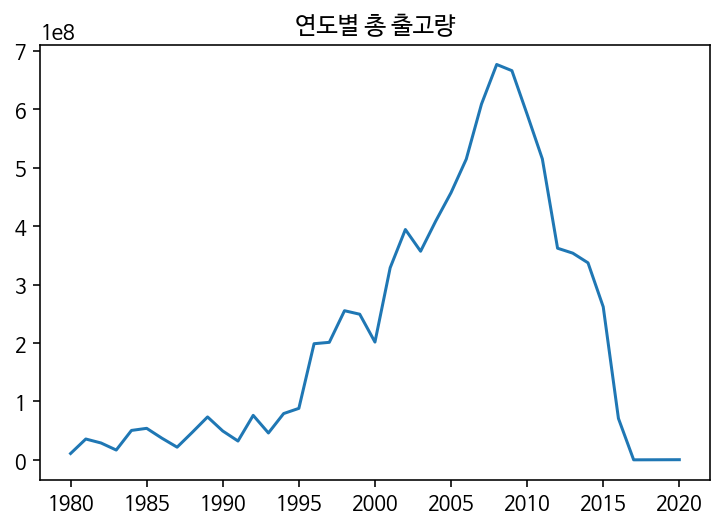

In [ ]:
#연도별 게임의 트렌드가 있을까?
#1)연도별 비디오 게임 출고량 추세

plt.plot(data.groupby('Year')['total'].sum()) #연도별 비디오 게임의 총 출고량 시각화
plt.title('연도별 총 출고량')
plt.show()

비디오 게임 산업은 2005년~2010년에 가장 많은 출고량을 낸 것으로 확인된다.<br>
그 이후로는 점차 출고량이 감소하는 추세를 보인다.<br>
이는 컴퓨터 게임의 보급과 스마트폰의 상용화가 이루어졌기 때문으로 예상된다.

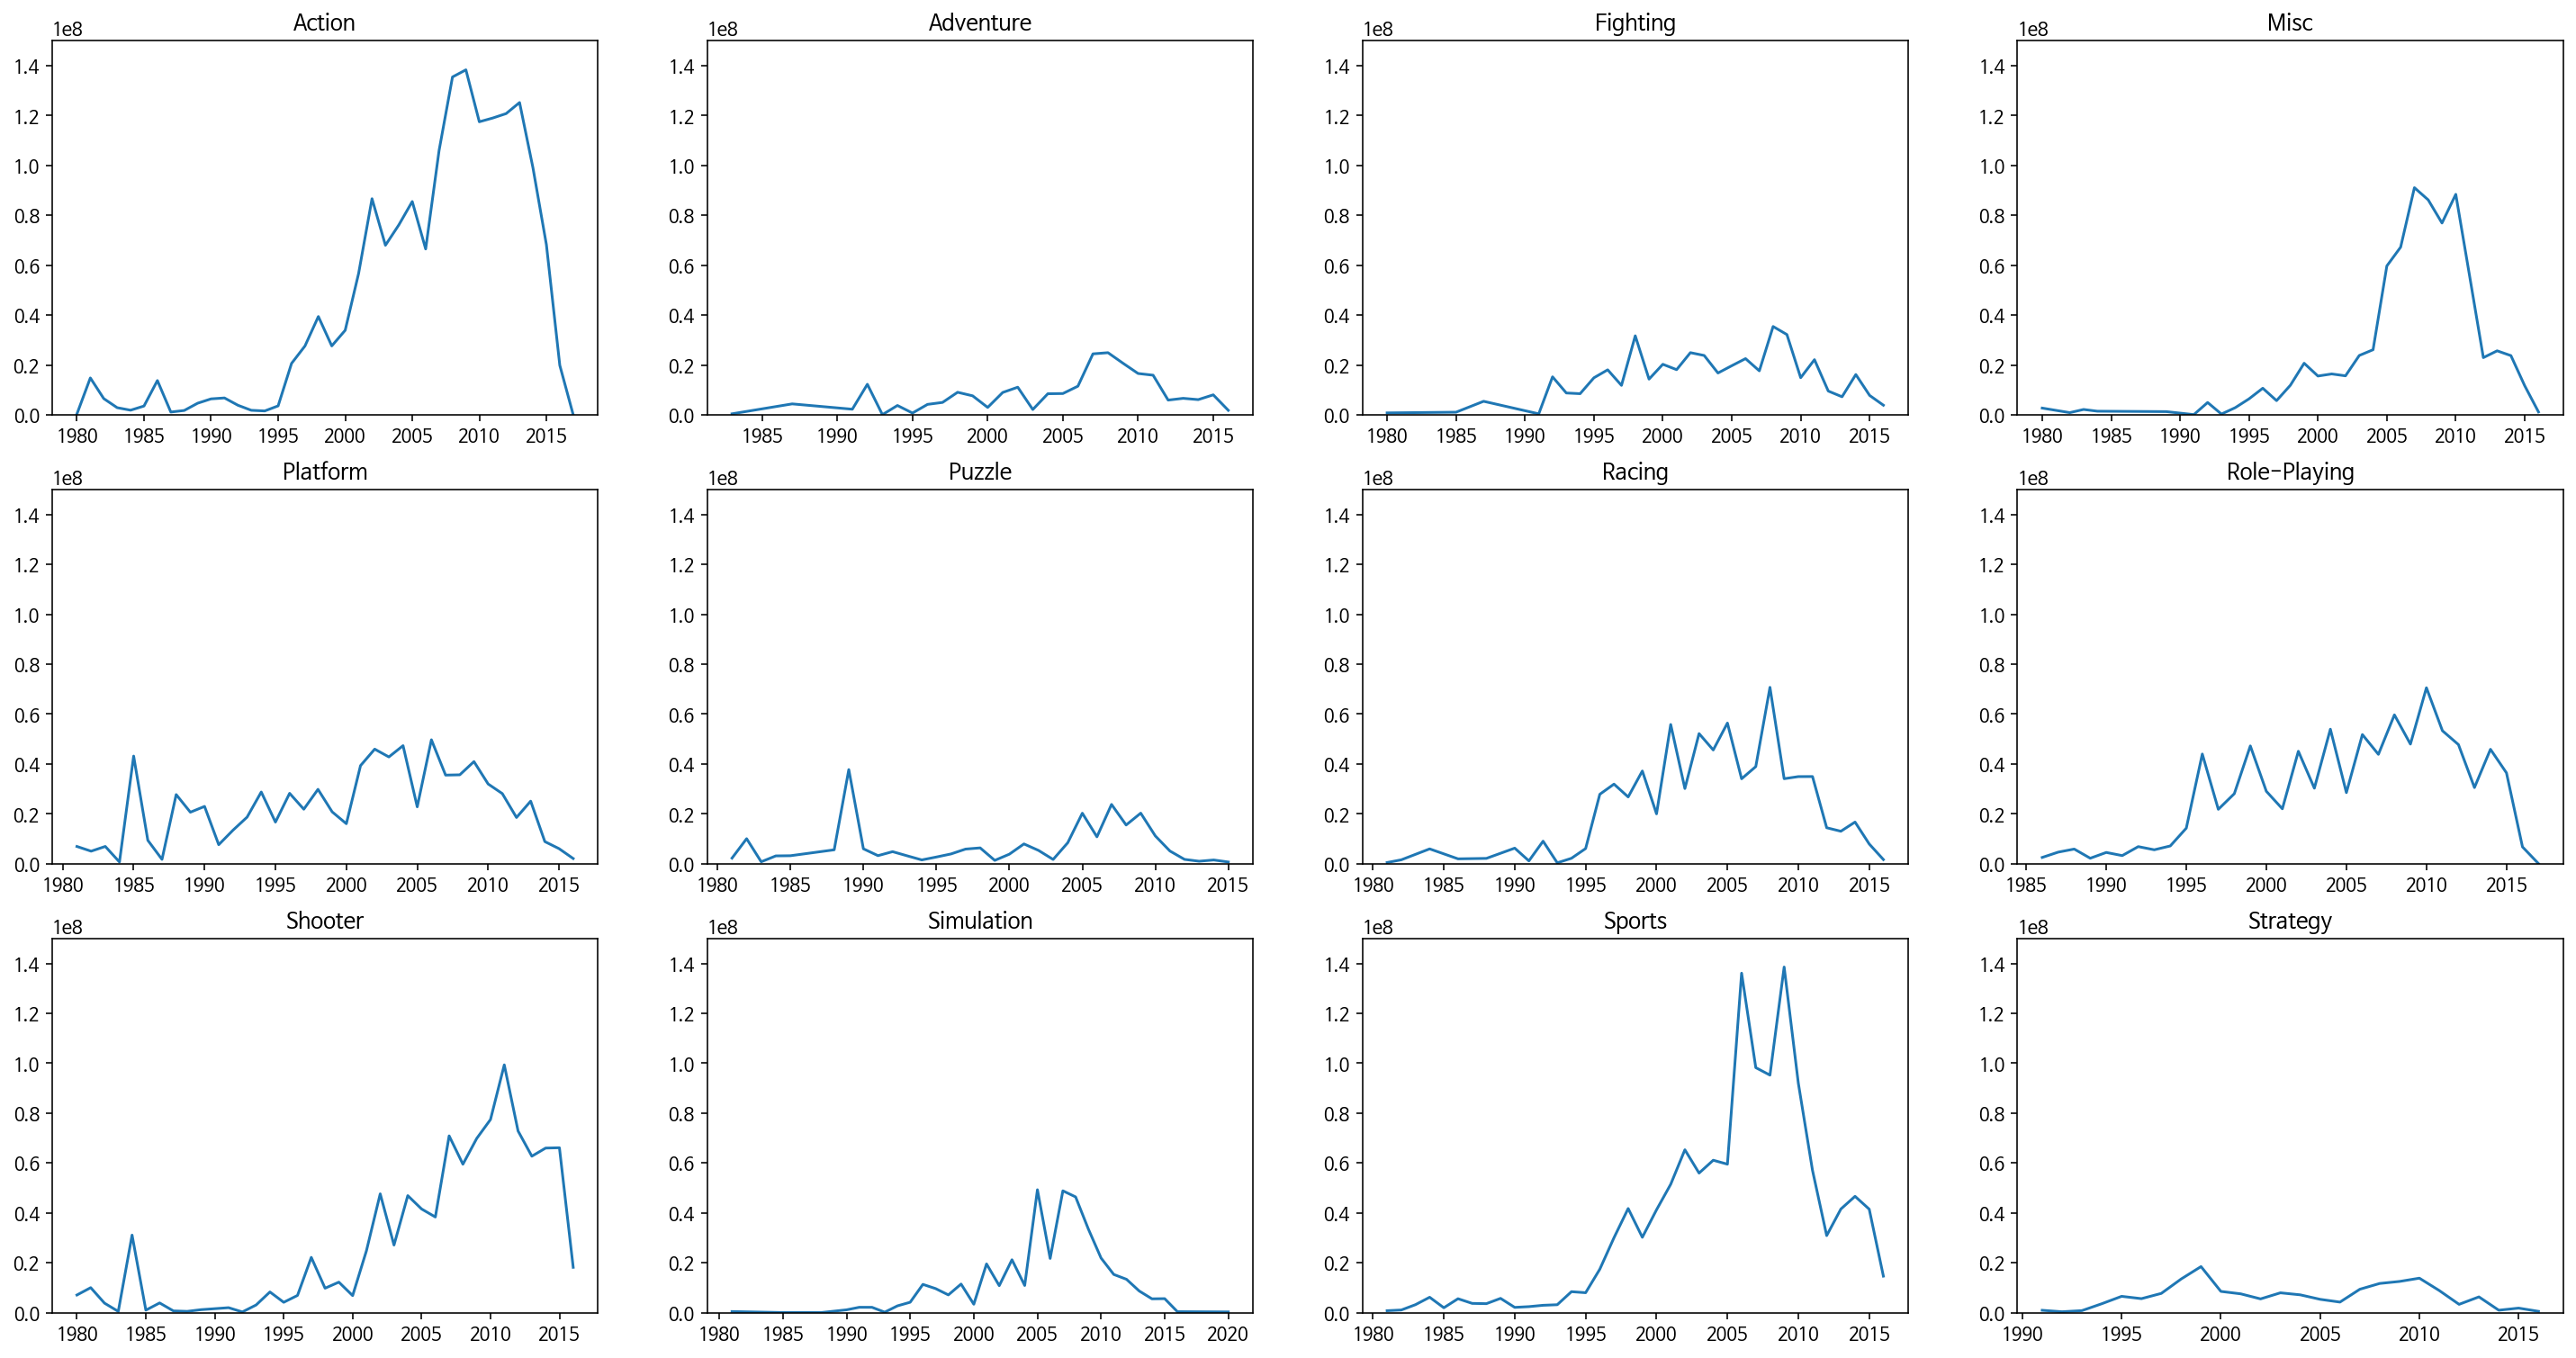

In [ ]:
#2)연도별 비디오 게임 장르의 트렌드

gen = list(data['Genre'].unique())

gen.sort()

fig2, ax2 = plt.subplots(3,4, figsize=(25,13))

for i, ge in enumerate(gen): #row 설정
    if i <= 3:
        r = 0
    elif i > 3 and i <= 7:
        r = 1
    elif i > 7 and i <= 11:
        r = 2

    j = i % 4 #column 설정

    df = data[data['Genre'] == ge]

    df2 = df.groupby('Year')['total'].sum()

    ax2[r,j].plot(df2)
    ax2[r,j].set_title(ge)
    ax2[r,j].set_ylim(0,150000000)
plt.show()

In [ ]:
#출고량이 높은 게임에 대한 분석 및 시각화 프로세스

big_game = data.copy()

big_game.index = big_game['Name']

print('모든 시기의 출고량 상위 5종목 : \n', big_game['total'].nlargest(5)) #상위 5개 출고량 높은 게임
print('\n최근 출고량 상위 5종목 : \n', big_game[big_game['Year'] >= 2015]['total'].nlargest(5))

모든 시기의 출고량 상위 5종목 : 
 Name
Wii Sports                  82740000.0
Super Mario Bros.           40240000.0
Mario Kart Wii              35830000.0
Wii Sports Resort           33000000.0
Pokemon Red/Pokemon Blue    31380000.0
Name: total, dtype: float64

최근 출고량 상위 5종목 : 
 Name
Call of Duty: Black Ops 3       14240000.0
FIFA 16                          8490000.0
Star Wars Battlefront (2015)     7670000.0
Call of Duty: Black Ops 3        7290000.0
Fallout 4                        6960000.0
Name: total, dtype: float64


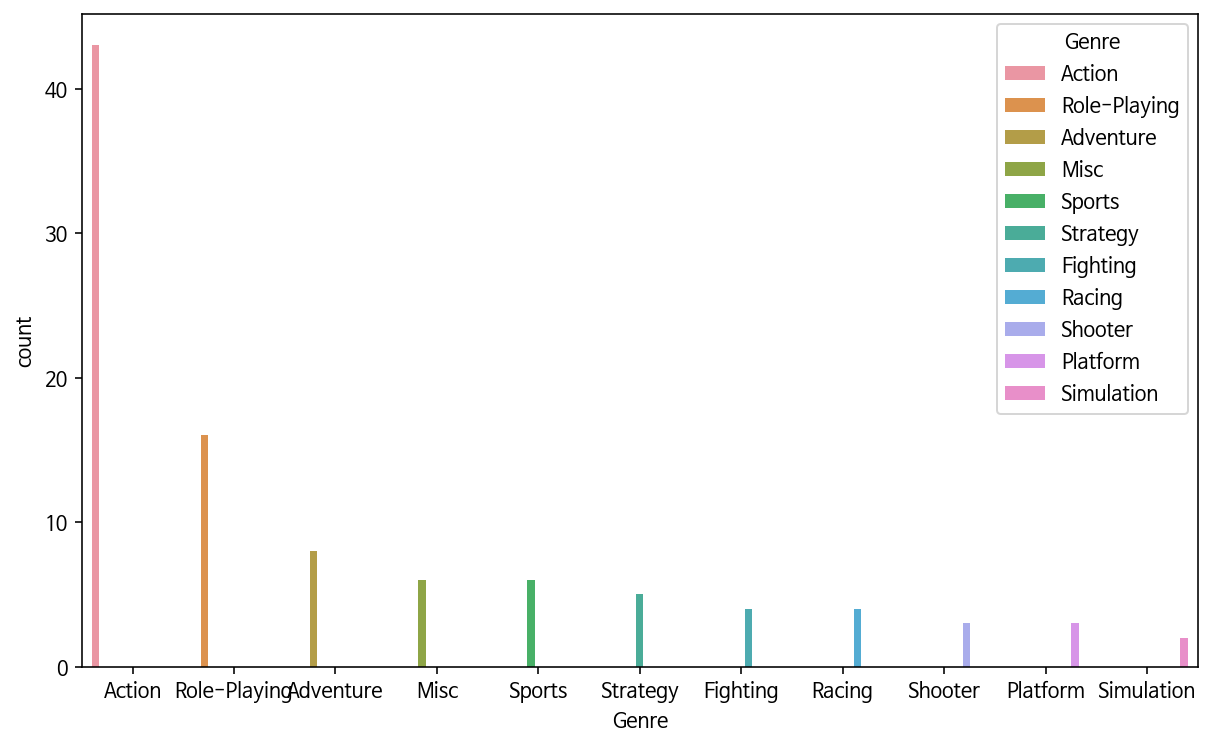

In [ ]:
#최근 트랜드를 반영한 출시가 많이 되는 장르

best = big_game[big_game['Year'] >= 2015].iloc[:100]['Genre'].value_counts()
best = pd.DataFrame(best)
best.reset_index(inplace = True)
best.columns = ['Genre', 'count']

plt.figure(figsize=(10,6))

sns.barplot(
    x = 'Genre',
    y = 'count',
    data = best,
    hue = 'Genre'
);

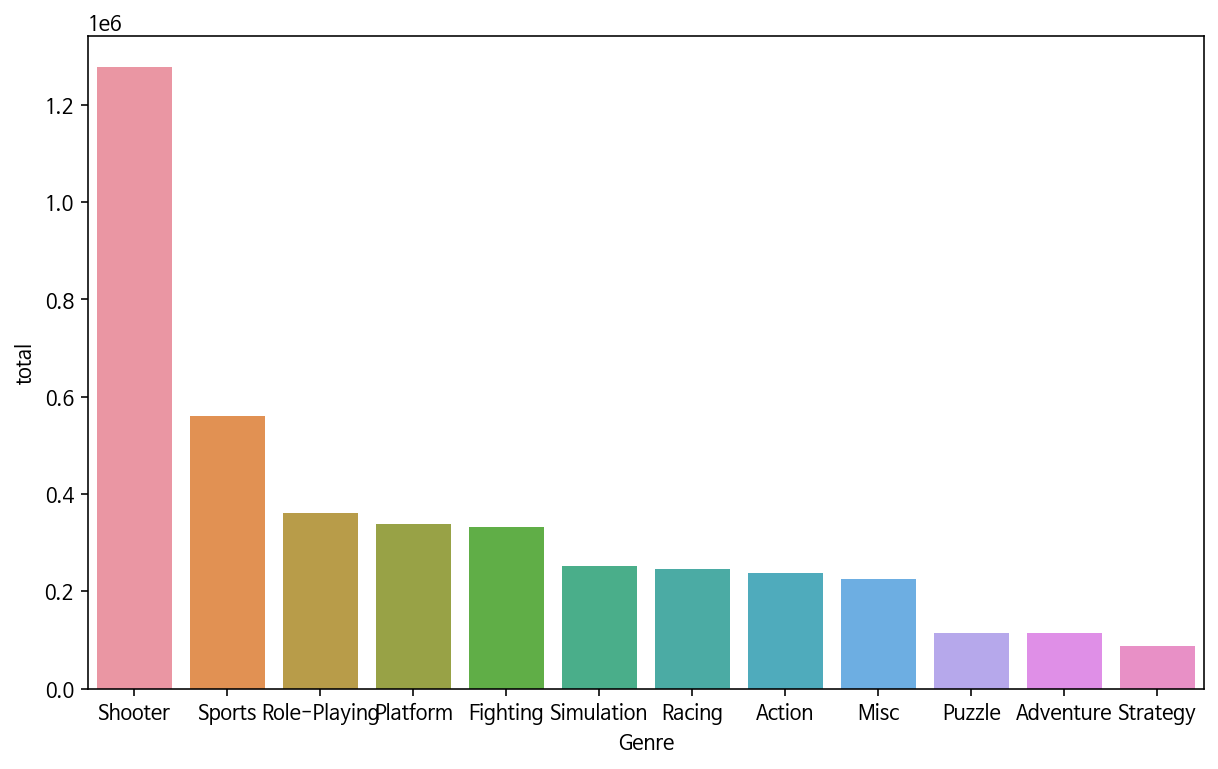

In [ ]:
#최근 장르별 출고량 평균 순위

Genre_total_trend = pd.DataFrame(big_game[big_game['Year']>=2015].groupby('Genre')['total'].mean())
Genre_total_trend.reset_index(inplace = True)
Genre_total_trend.sort_values('total', ascending = False, inplace = True)

plt.figure(figsize = (10,6))

sns.barplot(
    x='Genre',
    y='total',
    data=Genre_total_trend
);

Shooter, Sports, Role-playing이 상위 출고량 장르에 속해있다.

In [ ]:
# 출고량 상위 3 Genre 평균 비교, Shooter, Sports, Role-Playing 과연 sales에서 유의미한 차이가 있을까?(ANOVA)

trend = big_game[big_game['Year'] >= 2015] #trend반영

group1 = trend[trend['Genre'] == 'Shooter']['total']
group2 = trend[trend['Genre'] == 'Sports']['total']
group3 = trend[trend['Genre'] == 'Role-Playing']['total']

#Shooter, Sports , Role-playing ANOVA
p_value_ano = stats.f_oneway(group1, group2, group3).pvalue

if p_value_ano >= 0.05:
    print('Shooter, Sports, Role-Playing 세 그룹간 평균이 유의미하게 차이나지 않습니다.')
else:
    print('Shooter, Sports, Role-Playing 세 그룹간 평균이 적어도 하나는 유의미하게 차이납니다.')

Shooter, Sports, Role-Playing 세 그룹간 평균이 적어도 하나는 유의미하게 차이납니다.


In [ ]:
# Shooter, Sports t-test, 두 데이터는 연관성이 없다고 판단

#표본이 많으므로 정규성을 만족한다고 생각


#등분산 test
p_value_var = stats.levene(group1, group2).pvalue

if p_value_var >= 0.05:
    print('Shooter, Sports 두 그룹은 등분산이다.')
else:
    print('Shooter, Sports 두 그룹은 등분산이 아니다.')

#독립 t-test, 단측검정:
p_value_t = stats.ttest_ind(group1, group2, equal_var = False, alternative = 'greater').pvalue

if p_value_t >= 0.05:
    print('Shooter, Sports 두 그룹간 평균이 유의미하게 차이나지 않습니다.')
else:
    print('Shooter, Sports 두 그룹간 평균이 Shooter가 더 크다.')

Shooter, Sports 두 그룹은 등분산이 아니다.
Shooter, Sports 두 그룹간 평균이 Shooter가 더 크다.


In [ ]:
#최근 shooter를 통한 CI 계산
avg = np.mean(group1)
se = np.std(group1)/np.sqrt(len(group1))

ci = stats.t.interval(.95, loc = avg, scale = se, df = len(group1)-1)

print('Shooter 평균 출고량의 confidence interval : ', (round(ci[0],3), round(ci[1], 3)))

Shooter 평균 출고량의 confidence interval :  (719975.153, 1834267.271)


위 ANOVA, t-test의 결과를 보았을때, 최근(2015년 이후)에는 전세계적으로 Shooter 게임의 출고량 평균이 가장 높다는 것을 알 수 있다.

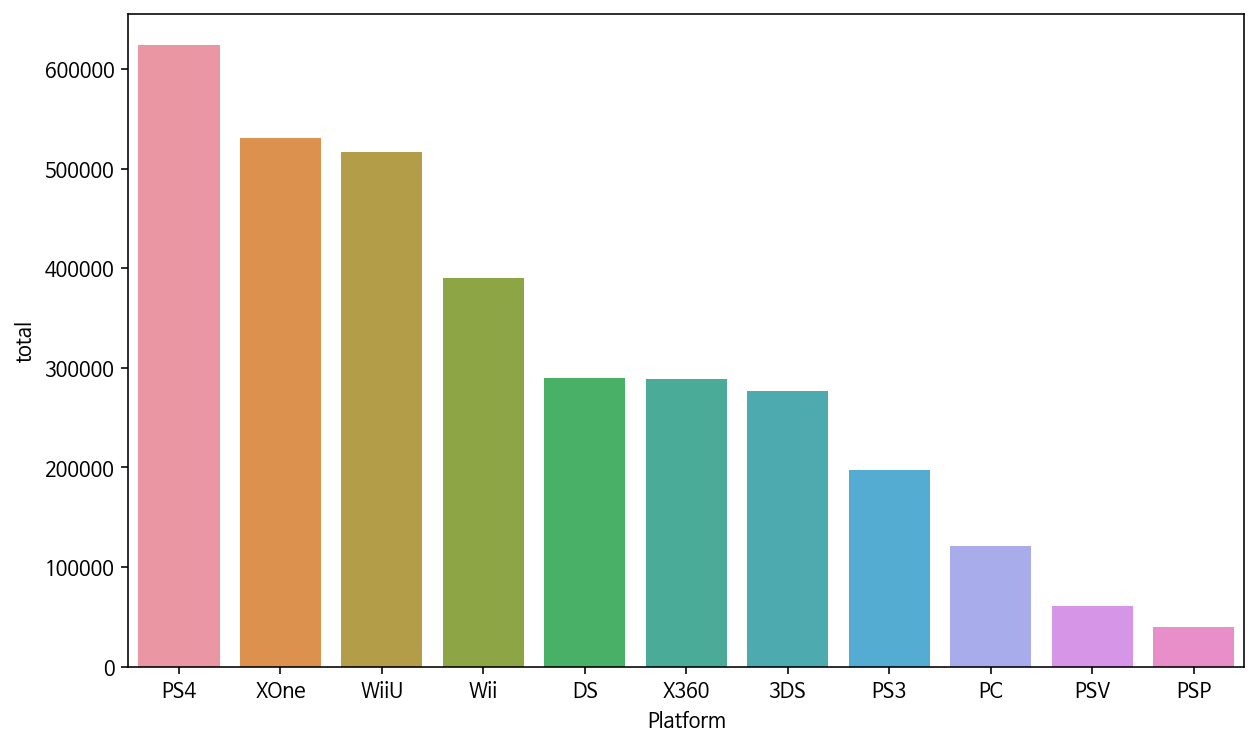

In [ ]:
# 최근 평균 출고량이 가장 높은 플랫폼

Platform_total_trend = pd.DataFrame(big_game[big_game['Year']>=2015].groupby('Platform')['total'].mean())
Platform_total_trend.reset_index(inplace = True)
Platform_total_trend.sort_values('total', ascending = False, inplace = True)

plt.figure(figsize = (10,6))

sns.barplot(
    x='Platform',
    y='total',
    data=Platform_total_trend
);

In [ ]:
#PS4에서 shooter 게임을 잘 만들까??

PS4 = big_game[big_game['Platform']=='PS4']

PS4['Genre'].value_counts()

Action          121
Role-Playing     47
Sports           43
Shooter          34
Adventure        19
Racing           17
Fighting         17
Misc             15
Platform         11
Simulation        5
Strategy          5
Puzzle            1
Name: Genre, dtype: int64

In [ ]:
PS4.groupby('Genre')['total'].sum().sort_values(ascending=False)

Genre
Action          84700000.0
Shooter         75320000.0
Sports          50100000.0
Role-Playing    25780000.0
Racing          11570000.0
Fighting         8040000.0
Misc             7370000.0
Platform         6990000.0
Adventure        4700000.0
Simulation        770000.0
Strategy          420000.0
Puzzle             20000.0
Name: total, dtype: float64

In [ ]:
PS4.groupby('Genre')['total'].mean().sort_values(ascending=False)

Genre
Shooter         2.215294e+06
Sports          1.165116e+06
Action          7.000000e+05
Racing          6.805882e+05
Platform        6.354545e+05
Role-Playing    5.485106e+05
Misc            4.913333e+05
Fighting        4.729412e+05
Adventure       2.473684e+05
Simulation      1.540000e+05
Strategy        8.400000e+04
Puzzle          2.000000e+04
Name: total, dtype: float64

In [ ]:
#shooter을 가장 잘 지원해줄 수 있는 platform은??

shooter_platform = pd.DataFrame(big_game[big_game['Genre'] == 'Shooter'].groupby('Platform')['total'].sum().sort_values(ascending=False))
shooter_platform.reset_index(inplace = True)

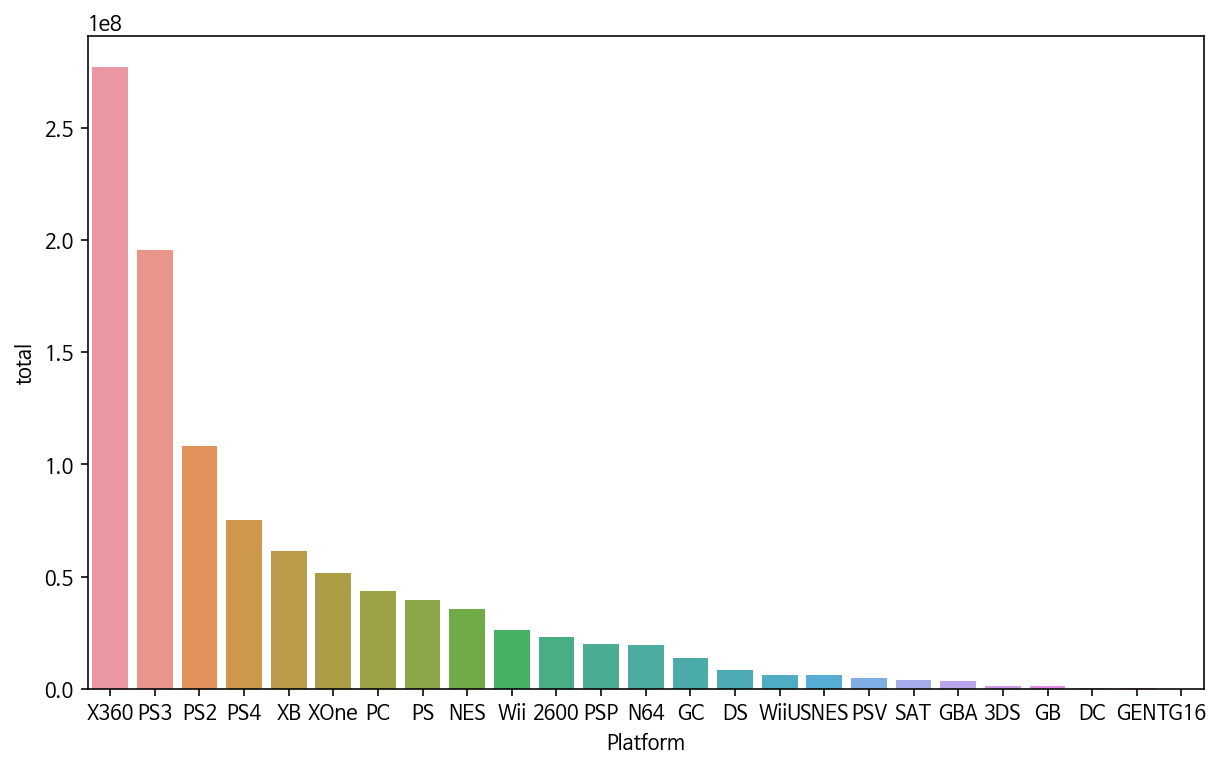

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(
    x='Platform',
    y='total',
    data=shooter_platform
);

In [ ]:
#두 변수간의 연관성

cross_chi2  = data[['Genre', 'Platform','total']]

cross_chi2 = pd.crosstab(cross_chi2['Genre'], cross_chi2['Platform'])

p_value_chi2 = stats.chi2_contingency(cross_chi2, correction = False)[1]

if p_value_chi2 >= 0.05:
    print('Genre와 Platform 사이의 연관성이 존재한다.')
else:
    print('Genre와 Platform 사이의 연관성이 존재하지 않는다.')

Genre와 Platform 사이의 연관성이 존재하지 않는다.


특정 플랫폼이 특정 장르를 독점하고 있지 않다고 해석해볼 수 있다.<br>
-> 모든 플랫폼이 골고루 shooter 게임을 지원하고있다.<br>
-> 경쟁사가 많음에도 X360은 shooter에서 가장 높은 출고량을 보인다.

In [ ]:
cross_chi2

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,55,0,180,3,335,6,162,98,3,0,36,13,0,160,0,153,344,369,121,216,141,3,0,12,0,0,229,63,318,152,68
Adventure,1,1,36,11,237,5,35,20,2,0,4,1,0,65,0,66,195,72,19,213,84,26,0,4,1,0,83,3,47,26,11
Fighting,1,0,14,12,36,0,23,42,5,0,29,4,11,5,0,108,146,76,17,73,16,31,0,25,0,0,41,5,64,44,7
Misc,5,0,53,0,388,8,86,35,1,0,17,2,0,22,0,76,217,121,15,104,24,15,2,17,0,0,270,21,122,45,15
Platform,9,0,28,2,89,18,139,73,7,1,30,28,0,11,0,64,101,35,11,35,10,5,1,26,0,0,57,16,24,49,4
Puzzle,8,1,19,0,235,15,39,11,0,0,12,14,0,25,0,32,18,2,1,43,3,5,0,13,0,0,53,4,6,7,0
Racing,4,0,10,6,66,2,64,60,1,0,56,4,0,56,0,143,212,90,17,65,11,8,1,9,0,0,91,3,100,121,19
Role-Playing,0,0,84,4,196,21,72,25,3,0,7,11,0,103,1,96,182,117,47,190,82,17,1,50,0,4,35,6,75,23,13
Shooter,22,0,6,3,42,1,40,48,1,0,24,7,0,145,0,96,158,155,34,37,5,22,0,10,1,0,60,10,197,123,33


### 5. 결론

* Shooter 게임을 만든다.<br>
* X360와 협력한다.<br>
* 일본을 제외한 모든 나라에서 마케팅을 시도해볼 수 있다. 특히 미국 시장을 노리자.<br>
* 가능한 빠르게 비디오 게임을 출시한다.
